In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime,timedelta
import pandas as pd

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut
import matplotlib.ticker as tkr

import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

In [2]:
mooring=1
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=mooring)
root_dir = '/Users/zcasparcohen/codes/NIW/'
#figdir = '/Users/zcasparcohen/Documents/Figures_poster/'

In [3]:
# Wind
wind_work = xr.open_dataset(root_dir+'data/ni_wind_work_niskine_m1.nc').rename({'__xarray_dataarray_variable__':'wind_work'})
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')

#Velocity time series
ds = xr.open_dataset(root_dir+'data/NI02_M%s.nc'%mooring)
gridded=xr.open_dataset(root_dir+'data/M%s_linear_merge_slinearfill.nc'%mooring)[['u','v']]
wkb = niskine.clim.get_wkb_factors(gridded)
ds['bpuz'] = wkb*ds['u_filtered'].differentiate('z')
ds['bpvz'] = wkb*ds['v_filtered'].differentiate('z')

ds['uz'] = wkb*ds['u'].differentiate('z')
ds['vz'] = wkb*ds['v'].differentiate('z')

#Vorticity
vort = xr.open_dataset(root_dir+'data/vorticity_moorings.nc')
vort_alt = xr.open_dataset(root_dir+'data/vorticity_alt.nc')

#N
N2 = xr.open_dataset(root_dir+'data/N_daily.nc').rename({'__xarray_dataarray_variable__':'N2'})

#Low frequency motion
ds_low = xr.open_dataset(root_dir+'data/M%s_lpfiltered.nc'%mooring).interpolate_na(dim='time',method='cubic',max_gap=pd.Timedelta(3, "d"))

alt = niskine.io.load_ssh()
alt['eke'] = 1/2 * (alt.ugosa**2 + alt.vgosa**2)
from datetime import datetime
eke = alt.eke.sel(time=slice('2019-06-01','2020-10-01'))#.plot()
_time = eke.time

In [233]:
ds

<xarray.Dataset>
Dimensions:     (time: 73057, z: 125)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-06
  * z           (z) int64 0 16 32 48 64 80 96 ... 1904 1920 1936 1952 1968 1984
Data variables: (12/13)
    u           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    u_filtered  (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v_filtered  (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    mld         (time) float64 ...
    bpu_wkb     (z, time) float64 ...
    ...          ...
    ni_ke_wkb   (z, time) float64 ...
    ni_ke       (z, time) float64 ...
    bpuz        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpvz        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    uz          (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    vz          (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

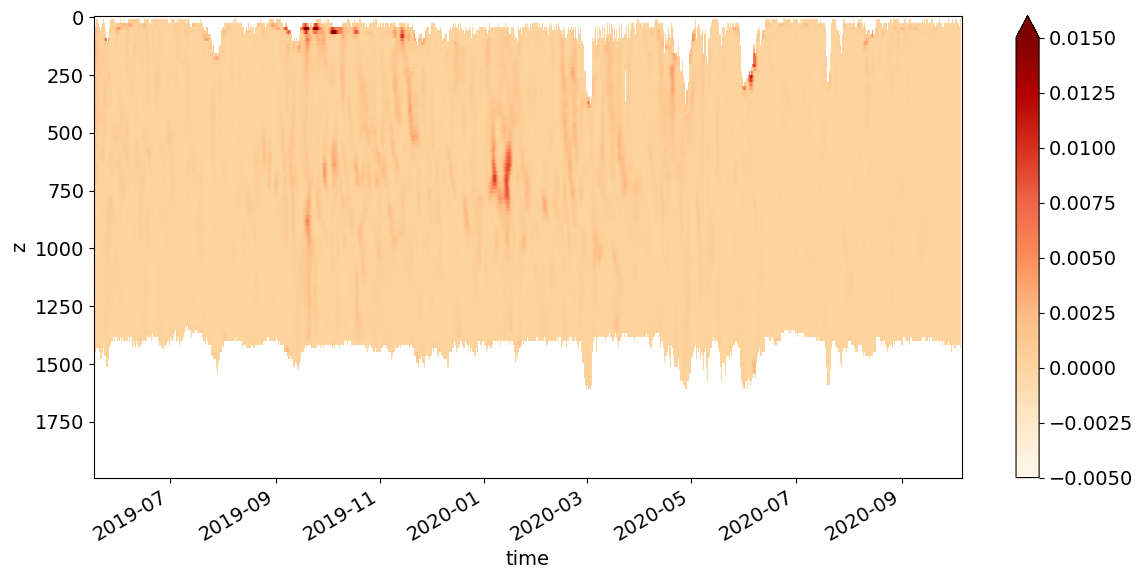

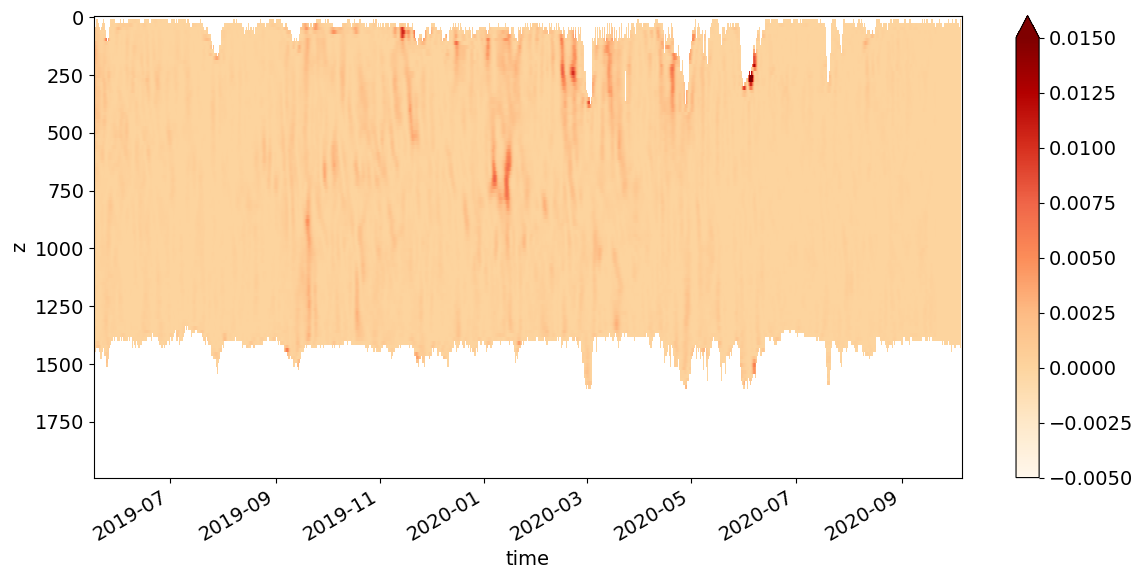

In [235]:
fig,ax = plt.subplots(figsize=(14,6))
(0.5*(ds.u_filtered**2+ds.v_filtered**2)).plot(ax=ax,yincrease=False,cmap='OrRd',vmax=0.015,vmin=-0.005)
fig,ax = plt.subplots(figsize=(14,6))
(0.5*(ds.bpu_wkb**2+ds.bpv_wkb**2)).plot(ax=ax,yincrease=False,cmap='OrRd',vmax=0.015,vmin=-0.005)


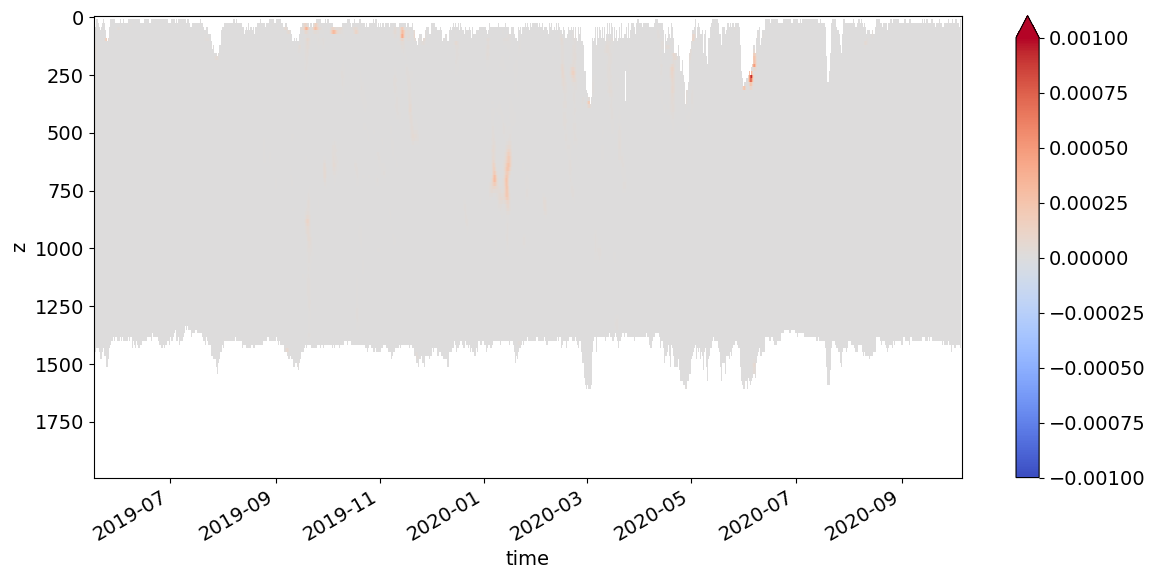

In [237]:
fig,ax = plt.subplots(figsize=(14,6))
(0.5*(ds.bpu_wkb**2+ds.bpv_wkb**2)/0.5*(ds.u_filtered**2+ds.v_filtered**2)).plot(ax=ax,yincrease=False,cmap='coolwarm',vmin=-1e-3,vmax=1e-3)

In [5]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        #if _ds1.dtype=='complex128':
        #    _kwargs = {'mode': 'full','detrend':detrend}
        #else:
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [16]:
from scipy import signal
_test = ds.u_filtered.sel(z=400).sel(time=slice('2019-06-01','2020-08-01'))

In [238]:
dt = 1/(24*6)
T_w = 30
N = T_w*24*6

In [239]:
fc = (ut.coriolis(lat)*3600*24)/(2*np.pi)
M2 = 1.932
S2 = 2
domega_M2 = (M2-fc)
domega_S2 = (S2-fc)

In [256]:
def wrap_correlate(v1,v2,**kwargs):
    kwargs.update(kwargs)
    ds_out = xr.apply_ufunc(correlate_E,v1,v2,
                   input_core_dims = [['time'],['time']],
                   output_core_dims=[['lags']],
                   kwargs=kwargs)
    ds_out = ds_out.assign_coords({'lags':np.arange(N//2+1)*dt}).rename({'correlation'})
    return ds_out

In [257]:
ds_out = {}
for V in ['u','v']:
    ds_out[V+'_cov'] = wrap_correlate(ds[V+'_filtered'].sel(time=slice('2019-06-01','2020-08-01')).fillna(0),
                                      ds[V+'_filtered'].sel(time=slice('2019-06-01','2020-08-01')).fillna(0),
                                      dt=dt,roll=True,detrend=True,Nr=N)
ds_out = xr.Dataset(ds_out)

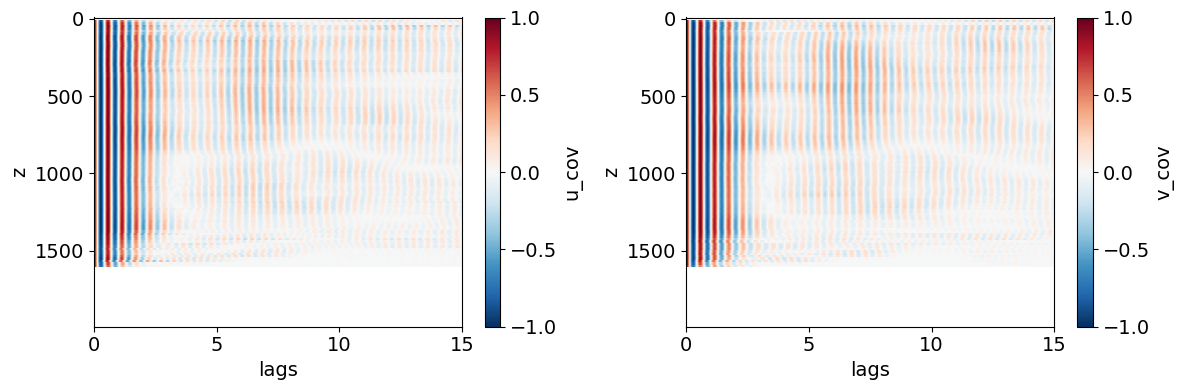

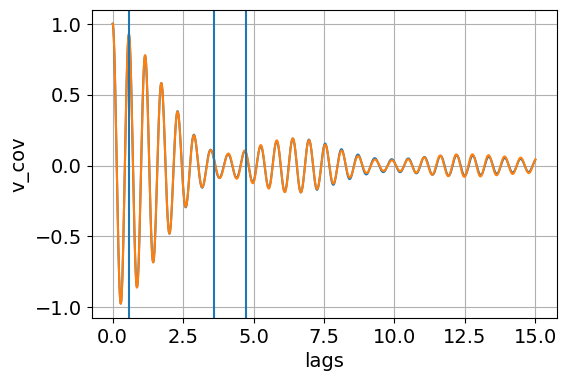

In [259]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
for v,ax in zip(['u_cov','v_cov'],axs):
    (ds_out[v]/ds_out[v].isel(lags=0)).plot(ax=ax,yincrease=False)
fig.tight_layout()
fig,axs = plt.subplots(figsize=(6,4))
for v in ['u_cov','v_cov']:
    (ds_out[v]/ds_out[v].isel(lags=0)).mean('z').plot(ax=axs)
axs.grid();
axs.axvline(1/fc);
axs.axvline(1/domega_M2)
axs.axvline(1/domega_S2)

In [260]:
def wrap_hilbert(ds,fs=1/(24*6)):
    output_dtype = complex
    gufunc_kwargs = dict(output_sizes={'time': len(ds.time)})
    ds_copy = ds.copy()
    for v in ['u_filtered','v_filtered','bpu_wkb','bpv_wkb']:
        ds_copy[v+'_analytical'] = xr.apply_ufunc(signal.hilbert, ds[v].fillna(0), output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )
        ds_copy[v+'_envelope'] = np.abs(ds_copy[v+'_analytical'])
        ds_copy[v+'_phase'] = xr.DataArray(data=np.angle(ds_copy['u_filtered'+'_analytical']), dims=['z','time'],
                                           coords={'z':(['z'],ds_copy.z.values),'time':(['time'],ds_copy.time.values)})
        ds_copy[v+'_freq'] = xr.DataArray(data=(np.diff(ds_copy[v+'_phase'])/(2.0*np.pi) * fs), dims=['z','time'],
                                           coords={'z':(['z'],ds_copy.z.values),'time':(['time'],ds_copy.time.values[:-1])})
    return ds_copy

In [261]:
ds_complex = wrap_hilbert(ds)
ds_complex

<xarray.Dataset>
Dimensions:                (time: 73057, z: 125)
Coordinates:
  * time                   (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020...
  * z                      (z) int64 0 16 32 48 64 ... 1920 1936 1952 1968 1984
Data variables: (12/29)
    u                      (z, time) float64 nan nan nan nan ... nan nan nan nan
    v                      (z, time) float64 nan nan nan nan ... nan nan nan nan
    u_filtered             (z, time) float64 nan nan nan nan ... nan nan nan nan
    v_filtered             (z, time) float64 nan nan nan nan ... nan nan nan nan
    mld                    (time) float64 ...
    bpu_wkb                (z, time) float64 nan nan nan nan ... nan nan nan nan
    ...                     ...
    bpu_wkb_phase          (z, time) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0
    bpu_wkb_freq           (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
    bpv_wkb_analytical     (z, time) complex128 0j 0j 0j 0j ... -0j -0j -0j -0j
    bpv_wkb_envelope       (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    bpv_wkb_phase          (z, time) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0
    bpv_wkb_freq           (z, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 nan
Attributes:
    orientation:      down
    magdec:           -10.915967
    max_e:            0.2
    max_e_deviation:  2
    min_correlation:  64
    mooring:          M1
    sn:               13481
    project:          NISKINe
    Bin1Dist:         24.59
    NCells:           44
    CellSize:         16.0
    proc time:        2022-05-09T19:08:16

In [262]:
ds_complex = ds_complex.where(ds_complex.u_filtered_analytical != 0+1j*0)
ds_complex = ds_complex.where(np.isnan(ds_complex.bpu_wkb)==False)
U,V = 'u_filtered','v_filtered'
_u,_v = ds_complex[U+'_analytical'], ds_complex[V+'_analytical']

In [263]:
dt = 1/(24*6)
omega = fc #ut.coriolis(lat)*3600*24/(2*np.pi)
time = np.arange(0,_u.time.values.size*dt,dt)
exp  = np.exp(-1j*omega*2*np.pi*time)

In [264]:
ds_complex['exp'] = xr.DataArray(exp,coords={'time':time})

In [265]:
_  = xr.Dataset({'u':_u,'v':_v,'exp':(['time'],exp)})

In [266]:
_['demodu'] = _.u*_.exp
_['demodv'] = _.v*_.exp
_['demodu_r'] = _.demodu.real.interpolate_na('time').sel(z=slice(50,1400)).dropna('time')#.plot()#.dropna('time')
_['demodu_i'] = _.demodu.imag.interpolate_na('time').sel(z=slice(50,1400)).dropna('time')

_['demodv_r'] = _.demodv.real.interpolate_na('time').sel(z=slice(50,1400)).dropna('time')
_['demodv_i'] = _.demodv.imag.interpolate_na('time').sel(z=slice(50,1400)).dropna('time')

_['demodu_'] = _['demodu_r'] + 1j*_['demodu_i']
_['demodv_'] = _['demodv_r'] + 1j*_['demodv_i']

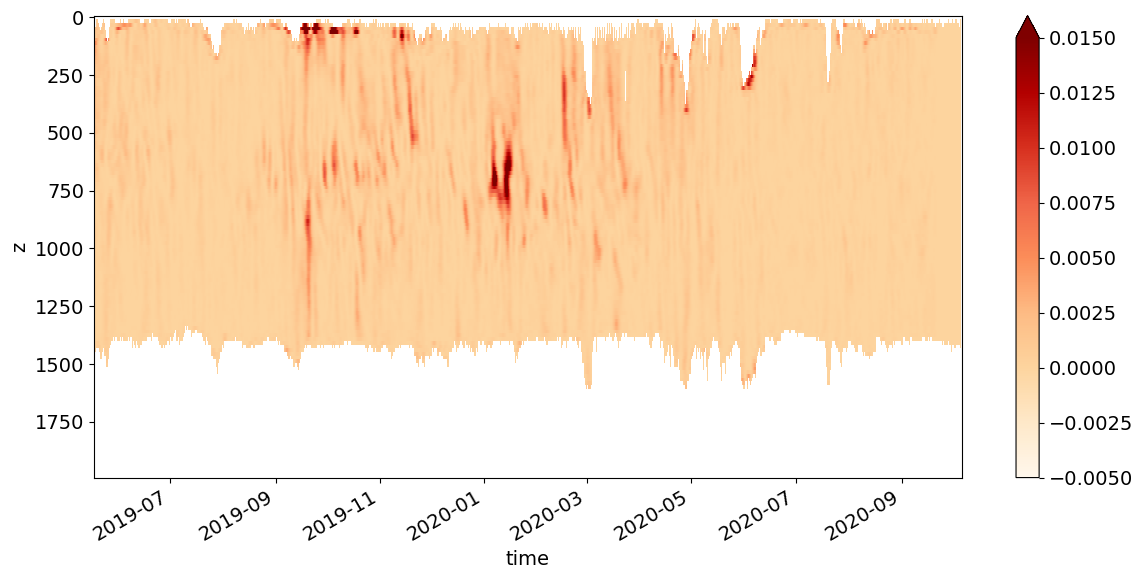

In [272]:
fig,ax = plt.subplots(figsize=(14,6))
(0.5*(np.abs(_['demodu'])**2+np.abs(_['demodv'])**2)).plot(ax=ax,yincrease=False,cmap='OrRd',vmax=0.015,vmin=-0.005)

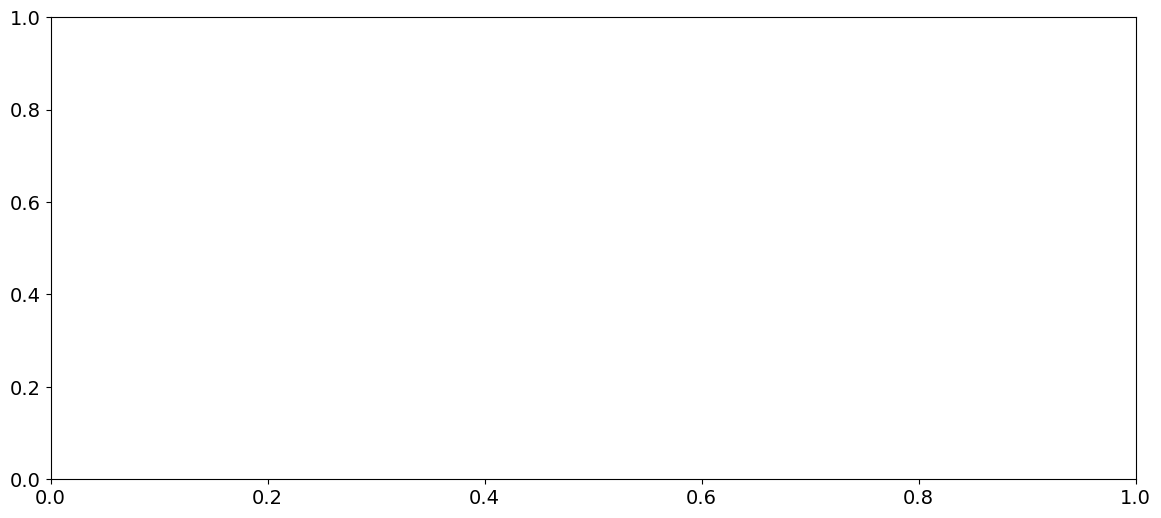

In [282]:
fig,ax = plt.subplots(figsize=(14,6))
#cb = ax.contourf(_.np.angle(_['demodu']))
#plt.colorbar(cb)

In [267]:
ds_out = {}
for V in ['demodu_r','demodv_r']:
    ds_out[V+'_cov'] = wrap_correlate(_[V].sel(time=slice('2019-06-01','2020-08-01')).fillna(0),
                                      _[V].sel(time=slice('2019-06-01','2020-08-01')).fillna(0),
                                      dt=dt,roll=True,detrend=True,Nr=N)
ds_out = xr.Dataset(ds_out)

Text(0, 0.5, 'Autocorrelation')

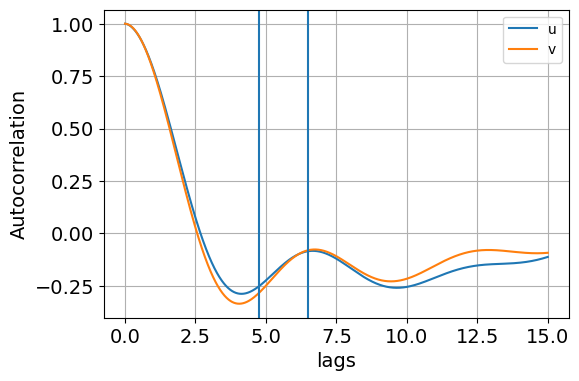

In [286]:
fig,axs = plt.subplots(figsize=(6,4))
for v in ['demodu_r_cov','demodv_r_cov']:
    (ds_out[v]/ds_out[v].isel(lags=0)).mean('z').plot(ax=axs,label='%s'%v[5])
axs.grid();axs.legend()
#axs.axvline(1/fc);
axs.axvline(1/domega)
axs.axvline(6.5)
#axs.axvline(13)
axs.set_ylabel('Autocorrelation')

In [253]:
#### Notes
print('Oscillation around 6.5 days period.') 
print('It corresponds to a frequency of %s cpd'%str((1+6.5*fc)/6.5))

Oscillation around 6.5 days period.
It corresponds to a frequency of 1.8747005530072767 cpd


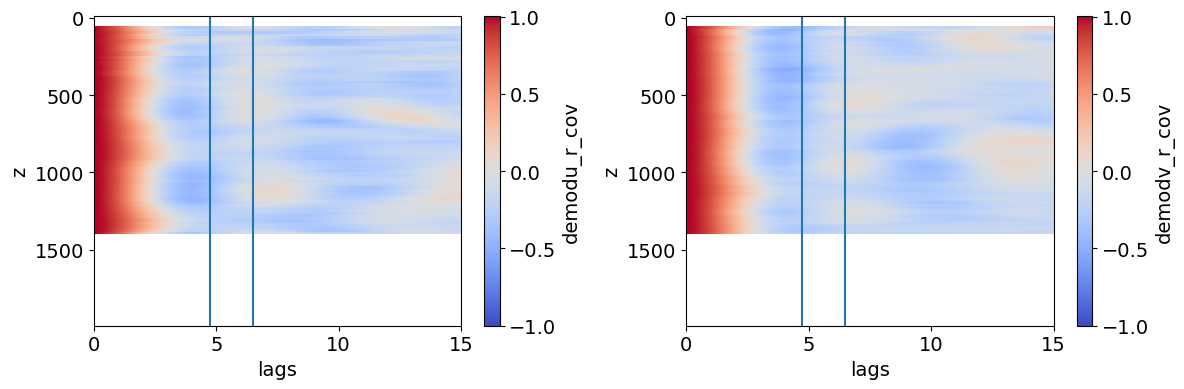

In [254]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
for v,ax in zip(['demodu_r_cov','demodv_r_cov'],axs):
    (ds_out[v]/ds_out[v].isel(lags=0)).plot(ax=ax,yincrease=False,cmap='coolwarm')
    ax.axvline(1/domega);
    ax.axvline(6.5)
fig.tight_layout()

In [287]:
xr.open_dataset('/Users/zcasparcohen/Downloads/gdp_combined_attrs.nc')

<xarray.Dataset>
Dimensions:                   (lon: 179, lat: 89)
Coordinates:
    dA                        (lat) float64 ...
    h                         (lon, lat) float64 ...
  * lat                       (lat) float64 -89.0 -87.0 -85.0 ... 83.0 85.0 87.0
  * lon                       (lon) float64 -179.0 -177.0 -175.0 ... 175.0 177.0
Data variables:
    semidiurnal_ve_abs2_mean  (lon, lat) float64 ...
    semidiurnal_vn_abs2_mean  (lon, lat) float64 ...
    dcount                    (lon, lat) float64 ...